# Model Training File



In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [2]:
# Paths
DATASET_PATH = "datasets/processed/"
LABELS_CSV = "datasets/processed_labels.csv"
MODEL_SAVE_PATH = "Model_Fix.h5"

In [3]:

# Load dataset labels
df = pd.read_csv(LABELS_CSV)
df["filename"] = df["filename"].apply(lambda x: os.path.join(DATASET_PATH, x))
print(df['label'].value_counts())  

# Perform train-validation split
train_files, val_files, train_labels, val_labels = train_test_split(
    df["filename"], df["label"], test_size=0.2, random_state=42
)

# Check dataset split
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")


label
1    29976
0    14256
Name: count, dtype: int64
Training samples: 35385
Validation samples: 8847


In [23]:
from sklearn.model_selection import train_test_split

# First split: Train (80%) + Temp (20%) → Temp will be further split into Val and Test
train_files, temp_files, train_labels, temp_labels = train_test_split(
    df["filename"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# Second split: Split Temp (20%) into Validation (10%) and Test (10%)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Print dataset sizes
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")
print(f"Test samples: {len(test_files)}")


Training samples: 35385
Validation samples: 4423
Test samples: 4424


In [24]:
test_images = np.array([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in test_files])
test_labels = np.array(test_labels)

# Expand dimensions to match model input shape (96, 96, 1)
test_images = np.expand_dims(test_images, axis=-1)

# Normalize pixel values
test_images = test_images.astype(np.float32) / 255.0

In [4]:


# Load images directly since they are already preprocessed
train_images = np.array([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in train_files])
val_images = np.array([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in val_files])
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Expand dimensions to match model input shape (96, 96, 1)
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)

# Ensure pixel values are in float32 and normalized to [0,1]
train_images = train_images.astype(np.float32) / 255.0
val_images = val_images.astype(np.float32) / 255.0


In [5]:
# Check the number of samples in train & validation sets
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

# Check class balance in both sets
train_df = pd.DataFrame({"filename": train_files, "label": train_labels})
val_df = pd.DataFrame({"filename": val_files, "label": val_labels})

print("\nTraining Set Distribution:")
print(train_df["label"].value_counts())

print("\nValidation Set Distribution:")
print(val_df["label"].value_counts())

Training samples: 35385
Validation samples: 8847

Training Set Distribution:
label
1    23947
0    11438
Name: count, dtype: int64

Validation Set Distribution:
label
1    6029
0    2818
Name: count, dtype: int64


In [6]:
print(f"Training data shape: {train_images.shape}")  # Should be (batch_size, 96, 96, 1)
print(f"Validation data shape: {val_images.shape}")  # Shou

Training data shape: (35385, 96, 96, 1)
Validation data shape: (8847, 96, 96, 1)


In [7]:
IMAGE_SIZE = 96
BATCH_SIZE = 32


batch_size = 50
validation_split = 0.1

epochs = 20,10,20
lrates = .001, .0005, .00025

color_mode = 'grayscale'
if color_mode == 'grayscale':
  n_color_chans = 1
elif color_mode == 'rgb':
  n_color_chans = 3
else:
  raise ValueError("color_mode should be either 'rgb' or 'grayscale'")

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

def tinyml_mobilenet():
    input_shape = (96, 96, 1)  # Ensure grayscale input
    num_classes = 1  # Binary classification: Dog vs Not-Dog
    num_filters = 8  # Reduced filters for TinyML

    inputs = Input(shape=input_shape)
    

    # 1st Layer: Standard Convolution
    x = Conv2D(num_filters, (3,3), strides=2, padding='same', 
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # 2nd Layer: Depthwise Separable Convolution
    x = DepthwiseConv2D((3,3), strides=1, padding='same', 
                         depthwise_initializer='he_normal', depthwise_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters *= 2  # Increase filters
    x = Conv2D(num_filters, (1,1), strides=1, padding='same', 
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 3rd Layer: Depthwise Separable Convolution
    x = DepthwiseConv2D((3,3), strides=2, padding='same', 
                         depthwise_initializer='he_normal', depthwise_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters *= 2  # Increase filters
    x = Conv2D(num_filters, (1,1), strides=1, padding='same', 
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 4th Layer: Depthwise Separable Convolution
    x = DepthwiseConv2D((3,3), strides=1, padding='same', 
                         depthwise_initializer='he_normal', depthwise_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 5th Layer: Depthwise Separable Convolution
    x = DepthwiseConv2D((3,3), strides=2, padding='same', 
                         depthwise_initializer='he_normal', depthwise_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters *= 2  # Increase filters
    x = Conv2D(num_filters, (1,1), strides=1, padding='same', 
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)  # Prevent overfitting

    # Output Layer
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification (Dog/Not-Dog)

    # Define Model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Compile the Model
model = tinyml_mobilenet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Display Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 8)      │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 48, 48, 8)      │            72 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 16)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 24, 24, 16)     │           144 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 32)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 24, 24, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_3              │ (None, 12, 12, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │             

 Total params: 12,833 (50.13 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 416 (1.62 KB)

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight  # Correct import


# Image size and batch size
IMG_SIZE = (96, 96)
BATCH_SIZE = 16
EPOCHS = 30  # Will stop early if needed
# 🔥 Dataset Summary
label_counts = {
    0: 14256,  # Not-Dog
    1: 29976   # Dog
}
TOTAL_SAMPLES = sum(label_counts.values())
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Compute class weights based on dataset size
class_counts = np.array([label_counts[0], label_counts[1]])  # [Not-Dog, Dog]
classes = np.array([0, 1])  # Labels: Not-Dog (0), Dog (1)

class_weights = compute_class_weight("balanced", classes=classes, y=np.repeat(classes, class_counts))
class_weights = {i: w for i, w in enumerate(class_weights)}

# Print computed class weights
print(f"Computed Class Weights: {class_weights}")

# Define Model
model = tinyml_mobilenet()  # Call your updated model function

# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights,  # Apply class balancing
    callbacks=[early_stopping]
)

MODEL_SAVE_PATH = "Final_Model_3.h5"
model.save(MODEL_SAVE_PATH)
print(f"✅ Model training complete! Saved as {MODEL_SAVE_PATH}")


Computed Class Weights: {0: 1.5513468013468013, 1: 0.7377902321857486}
Epoch 1/30
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.6162 - loss: 0.6811 - val_accuracy: 0.5126 - val_loss: 0.8159
Epoch 2/30
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.6704 - loss: 0.6291 - val_accuracy: 0.7337 - val_loss: 0.5596
Epoch 3/30
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.6943 - loss: 0.6020 - val_accuracy: 0.7292 - val_loss: 0.5615
Epoch 4/30
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7182 - loss: 0.5731 - val_accuracy: 0.6502 - val_loss: 0.6531
Epoch 5/30
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7228 - loss: 0.5621 - val_accuracy: 0.6965 - val_loss: 0.6004
Epoch 6/30
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7385 - loss: 0.5460 - val_accuracy: 0.5759 - val_loss: 0.8048
Epoch 7/30
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7436 - loss: 0.5409 - val_accuracy: 0.7534 - val_loss: 0.5196
Epoch

✅ Model training complete! Saved as Final_Model_3.h5


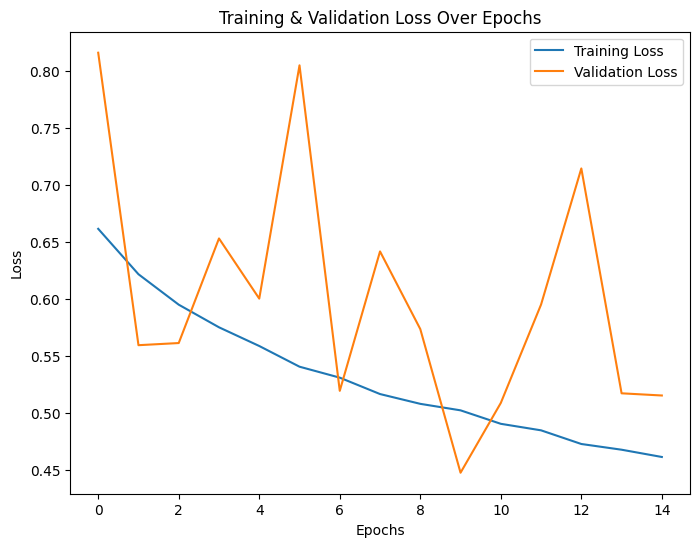

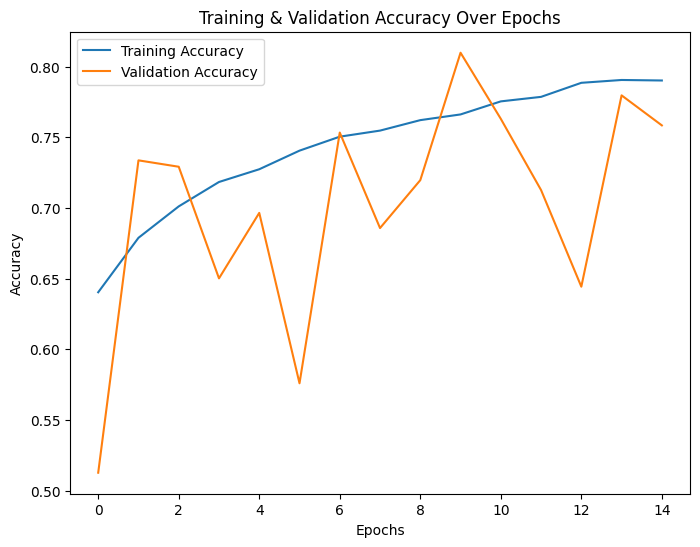

In [20]:



# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.applications import mobilenet_v2

# ✅ Load your trained model
#MODEL_PATH = "Final_Model.h5"  # Change to your actual model path
#model = tf.keras.models.load_model(MODEL_PATH)

# ✅ Extract Model Summary
model.summary()
print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Val images shape: {val_images.shape}, Val labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")

train_labels = np.array(train_labels).reshape(-1,)
val_labels = np.array(val_labels).reshape(-1,)
test_labels = np.array(test_labels).reshape(-1,)

if train_labels.ndim > 1:
    train_labels = np.argmax(train_labels, axis=1)
    val_labels = np.argmax(val_labels, axis=1)
    test_labels = np.argmax(test_labels, axis=1)

train_images = np.array([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in train_files])
val_images = np.array([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in val_files])
test_images = np.array([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in test_files])

# Expand dimensions to match model input shape
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Normalize to range [0,1]
train_images = train_images.astype(np.float32) / 255.0
val_images = val_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0


# ✅ Compute Accuracy for Training, Validation, and Test Data
train_loss, train_acc = model.evaluate(train_images, train_labels, verbose=0)
val_loss, val_acc = model.evaluate(val_images, val_labels, verbose=0)
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")


print(f"✅ Training Accuracy: {train_acc:.4f}")
print(f"✅ Validation Accuracy: {val_acc:.4f}")


# ✅ Compute Confusion Matrix for FPR & FRR
y_pred = (model.predict(test_images) > 0.5).astype(int)  # Convert probabilities to binary class
y_true = test_labels

conf_matrix = tf.math.confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf_matrix.numpy().ravel()

FPR = fp / (fp + tn)  # False Positive Rate
FRR = fn / (fn + tp)  # False Rejection Rate

print(f"❌ False Positive Rate (FPR): {FPR:.4f}")
print(f"❌ False Rejection Rate (FRR): {FRR:.4f}")

# ✅ Extract Input Tensor Shape
input_shape = model.input_shape
print(f"📌 Input Tensor Shape: {input_shape}")

# ✅ Compute Number of Parameters & MACs
total_params = model.count_params()

def count_macs(model):
    macs = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            filters = layer.filters  # Number of filters
            kernel_size = layer.kernel_size  # Kernel size (tuple)
            output_shape = layer.output.get_shape().as_list()[1:3]  # Get output height & width
            macs += np.prod(output_shape) * filters * np.prod(kernel_size)
        elif isinstance(layer, tf.keras.layers.Dense):
            macs += layer.input_shape[-1] * layer.units  # Fully connected layer
    return macs

total_macs = count_macs(model)

print(f"📊 Number of Parameters: {model.count_params()}")
print(f"📊 Multiply-Accumulate Operations (MACs): {total_macs}")






Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 48, 48, 8)      │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 48, 48, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_24             │ (None, 48, 48, 8)      │            72 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 48, 48, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 48, 48, 16)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_25             │ (None, 24, 24, 16)     │           144 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 24, 24, 32)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_26             │ (None, 24, 24, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_27             │ (None, 12, 12, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │             

 Total params: 37,669 (147.15 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 416 (1.62 KB)

 Optimizer params: 24,836 (97.02 KB)

Train images shape: (35385, 96, 96, 1), Train labels shape: (35385,)
Val images shape: (4423, 96, 96, 1), Val labels shape: (4423,)
Test images shape: (4424, 96, 96, 1), Test labels shape: (4424,)
✅ Test Accuracy: 0.8174
✅ Training Accuracy: 0.8222
✅ Validation Accuracy: 0.8083
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
❌ False Positive Rate (FPR): 0.3485
❌ False Rejection Rate (FRR): 0.1037
📌 Input Tensor Shape: (None, 96, 96, 1)


AttributeError: 'KerasTensor' object has no attribute 'get_shape'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Abyssinian_71.jpg: Not Dog (Confidence: 0.1972000002861023)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Bengal_194.jpg: Dog (Confidence: 0.9323999881744385)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Birman_1.jpg: Dog (Confidence: 0.5432000160217285)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
basset_hound_107.jpg: Dog (Confidence: 0.9664000272750854)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
dog10.jpg: Not Dog (Confidence: 0.21310000121593475)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
dog3.png: Dog (Confidence: 0.8320000171661377)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
dog4.png: Dog (Confidence: 0.9886000156402588)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
dog7.png: Dog (Confidence: 0.9502999782562256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
food2.png: Dog (Confidence: 0.6308000087738037)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
food4.png: Not Dog (Confidence: 0.37290000915527344)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
food6.png: Dog (Confidence: 0.7608000040054321)


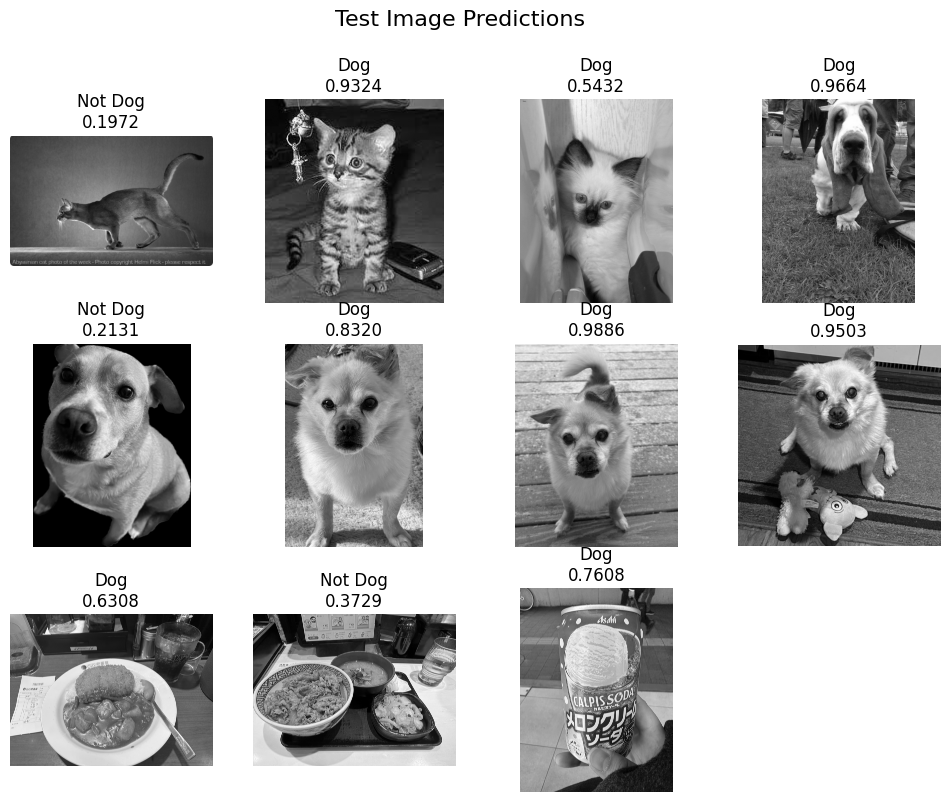

In [21]:


# Paths
MODEL_PATH = "tinyml_dog_model_3.h5"  # Path to trained model
IMAGE_PATH = "datasets/test_img/food2.png"  # Path to test image (replace with your image)
TEST_IMG_FOLDER = "datasets/test_img/"
# Load trained model
#model = tf.keras.models.load_model(MODEL_PATH)
#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# Image preprocessing (same as training)
IMG_SIZE = (96, 96)  # Ensure same size used in training


def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    if img is None:
        print(f"⚠️ Warning: Could not read {image_path}. Skipping...")
        return None

    img = cv2.resize(img, IMG_SIZE)  # Resize
    img = img.astype(np.float32) / 255.0  # Normalize

    img = np.expand_dims(img, axis=-1)  # Add grayscale channel dimension (96,96,1)
    img = np.expand_dims(img, axis=0)  # Add batch dimension (1,96,96,1)
    return img

# Function to run predictions on all images in the test folder
def run_predictions():
    test_images = sorted(os.listdir(TEST_IMG_FOLDER))  # Sort files for consistent display
    predictions = []
    images_to_show = []

    for file in test_images:
        if file.endswith((".jpg", ".png")):
            image_path = os.path.join(TEST_IMG_FOLDER, file)
            img = preprocess_image(image_path)
            
            if img is not None:
                prediction = model.predict(img)[0][0]  # Get prediction score
                label = "Dog" if prediction > 0.5 else "Not Dog"
                confidence = round(prediction, 4)

                print(f"{file}: {label} (Confidence: {confidence})")

                # Append image and prediction for visualization
                images_to_show.append(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))  # Read in grayscale
                predictions.append(f"{label}\n{confidence:.4f}")

    # Display images in a matrix
    display_results(images_to_show, predictions)

# Function to display test images and predictions in a grid
def display_results(images, predictions, cols=4):
    rows = (len(images) + cols - 1) // cols  # Calculate number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    fig.suptitle("Test Image Predictions", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap="gray")  # Display image in grayscale
            ax.set_title(predictions[i])  # Show prediction
            ax.axis("off")
        else:
            ax.axis("off")  # Hide extra subplots

    plt.show()

# Run the predictions
run_predictions()

In [19]:
import tensorflow as tf
import numpy as np

# Load the trained Keras model
#MODEL_SAVE_PATH = "tinyml_mobilenet_dog_detector.h5"
#model = tf.keras.models.load_model(model)

# Create a representative dataset function for quantization
def representative_dataset():
    for _ in range(100):
        sample = np.random.rand(1, 96, 96, 1).astype(np.float32)  # Fake grayscale images
        yield [sample]

# Convert the model to a fully quantized TensorFlow Lite model (int8)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # Force INT8
converter.inference_input_type = tf.int8  # Force int8 input
converter.inference_output_type = tf.int8  # Force int8 output

tflite_model = converter.convert()

# Save the quantized TFLite model
INT8_TFLITE_MODEL_PATH = "80kparam_model.tflite"
with open(INT8_TFLITE_MODEL_PATH, "wb") as f:
    f.write(tflite_model)

print(f"✅ INT8 Quantized Model Saved as {INT8_TFLITE_MODEL_PATH}")


INFO:tensorflow:Assets written to: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpj01illyh/assets


INFO:tensorflow:Assets written to: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpj01illyh/assets


Saved artifact at '/var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpj01illyh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_95')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  13459317456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13459318608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13459319568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13459318800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13459315344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13459320528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13459320144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13459321488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13459320720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13459318224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134593224

/Users/pkth002/Documents/Machine-Learning-for-IoT-main/_env/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1743379080.191819 3326056 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1743379080.191827 3326056 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-30 19:58:00.191924: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpj01illyh
2025-03-30 19:58:00.193045: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-30 19:58:00.193049: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpj01illyh
2025-03-30 19:58:00.206776: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-30 

✅ INT8 Quantized Model Saved as 80kparam_model.tflite


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [20]:
import tensorflow as tf

# Load the new INT8 model
interpreter = tf.lite.Interpreter(model_path="80kparam_model.tflite")
interpreter.allocate_tensors()

# Get input details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("✅ INT8 Model Loaded Successfully!")
print("📌 Input Type:", input_details[0]['dtype'])  # Should print int8
print("📌 Output Type:", output_details[0]['dtype'])  # Should print int8


✅ INT8 Model Loaded Successfully!
📌 Input Type: <class 'numpy.int8'>
📌 Output Type: <class 'numpy.int8'>


/Users/pkth002/Documents/Machine-Learning-for-IoT-main/_env/lib/python3.11/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [22]:
import tensorflow.lite as tflite

MODEL_PATH = "80kparam_model.tflite"
with open(MODEL_PATH, "rb") as f:
    model_data = f.read()

c_array = ", ".join(str(b) for b in model_data)

header_content = f"""#ifndef DOG_DETECT_MODEL_DATA_H_
#define DOG_DETECT_MODEL_DATA_H_

extern const unsigned char g_dog_detect_model_data[];
extern const int g_dog_detect_model_data_len;

#endif  // DOG_DETECT_MODEL_DATA_H_
"""

cpp_content = f"""#include "dog_detect_model_data.h"

const unsigned char g_dog_detect_model_data[] = {{
    {c_array}
}};

const int g_dog_detect_model_data_len = {len(model_data)};
"""

with open("dog_detect_model_data_2.h", "w") as f:
    f.write(header_content)

with open("dog_detect_model_data.cpp_2", "w") as f:
    f.write(cpp_content)

print("✅ Model converted successfully!")

✅ Model converted successfully!


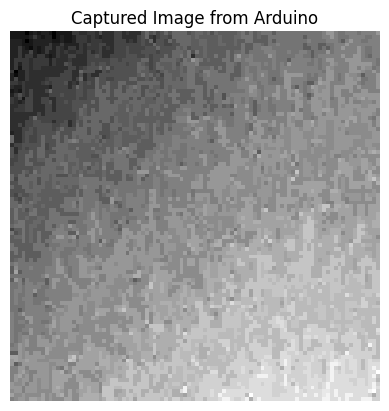

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# Load CSV file
file_path = "img1.csv"  # Change this to your filename

# Open file and remove hidden characters
with open(file_path, newline='', encoding='utf-8-sig') as f:
    reader = csv.reader(f)

    # Process each row, stripping extra spaces and filtering out empty lines
    image_data = []
    for row in reader:
        cleaned_row = [int(x.strip().replace('"', '')) for x in row if x.strip()]
        if cleaned_row:  # Ignore empty lines
            image_data.append(cleaned_row)

# Convert to NumPy array
image_data = np.array(image_data)

# Convert int8 (-128 to 127) to 0-255 grayscale
image_data = image_data + 128

# Display image
plt.imshow(image_data, cmap="gray")
plt.axis("off")
plt.title("Captured Image from Arduino")
plt.show()
